# Assessment 2: CNNs for image classification

In [1]:
## Data manioulation
import pandas as pd
import numpy as np
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [83]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA GeForce GTX 1650
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\cuda\memory.py:393: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  FutureWarning)


## Step01: Data exploration

In [70]:
## Download from Flowers102
training_data = datasets.CIFAR100(
    root="data",
    # split = 'train',
    train = True,
    download = True,
    transform= transforms.Compose([
        # transforms.Resize((32, 32)),  # Resize all images to 32x32
        transforms.ToTensor()
    ])
)

testing_data = datasets.CIFAR100    (
    root="data",
    # split = 'test',
    train = False,
    download = True,
    transform= transforms.Compose([
        transforms.Resize((32, 32)),  # Resize all images to 32x32
        # transforms.ToTensor()
    ])
)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data\cifar-100-python.tar.gz to data
Files already downloaded and verified


### Exploratory Image analysis

In [89]:
## check shape and labels
img, label = training_data[2]

print(img.shape,label)

torch.Size([3, 32, 32]) 0


Label : apple


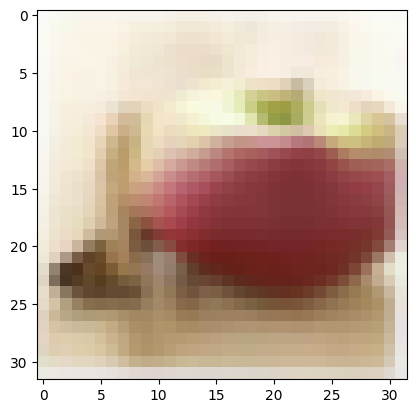

In [87]:
def display_img(img,label):
  print(f"Label : {training_data.classes[label]}")
  plt.imshow(img.permute(1,2,0)) # for visualization following the plt need to change the shapes

#display the first image in the dataset
display_img(*training_data[2])

In [91]:
batch_size = 64
## apply the dataloader
torch.manual_seed(0)
trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory = True
    )

testloader = torch.utils.data.DataLoader(
    testing_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory = True
    )

In [85]:
def custom_collate(batch):
    transform = transforms.ToTensor()
    images, labels = zip(*batch)
    images = [transform(img) for img in images]
    labels = torch.tensor(labels)
    return images, labels

trainloader = torch.utils.data.DataLoader(
    training_data,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=custom_collate
)

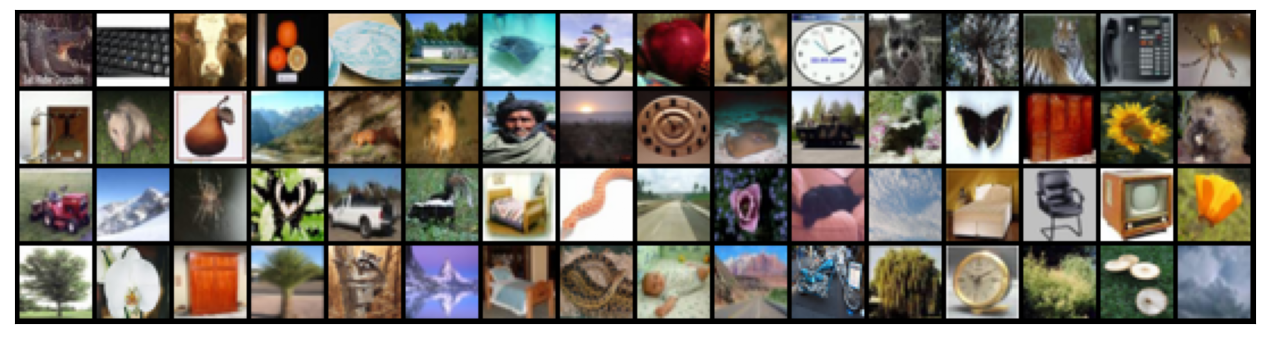

In [75]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_batch(dl):
    """Plot images grid of single batch"""
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=16).permute(1,2,0))
        break

show_batch(trainloader)

In [76]:
for batch in trainloader:
    print(batch[0].shape)  # Assuming batch[0] contains the data and batch[1] contains the labels
    break

torch.Size([64, 3, 32, 32])


### Base Model Functions For Image Classification

In [77]:
class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

### Hyperparameters, Model Training, And Evaluation:

In [78]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):

    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):

        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

## Initialize network

In [81]:
class SLP(ImageClassificationBase):
  def __init__(self):
    super(SLP, self).__init__()
    self.fc1 = nn.Linear(3*32*32,102)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = x.view(-1, 32*32*3) # reshape the input tensor
    x = self.fc1(x)
    x = self.sigmoid(x)
    return x

print(SLP())

SLP(
  (fc1): Linear(in_features=3072, out_features=102, bias=True)
  (sigmoid): Sigmoid()
)


In [68]:
class NaturalSceneClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(256,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(4096,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,102)
        )

    def forward(self, xb):
        return self.network(xb)

print(NaturalSceneClassification())

NaturalSceneClassification(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Lin

In [92]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.1
model = NaturalSceneClassification()
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\utils\data\_utils\worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\utils\data\_utils\fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\utils\data\_utils\collate.py", line 175, in default_collate
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\utils\data\_utils\collate.py", line 175, in <listcomp>
    return [default_collate(samples) for samples in transposed]  # Backwards compatibility.
  File "c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\utils\data\_utils\collate.py", line 183, in default_collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

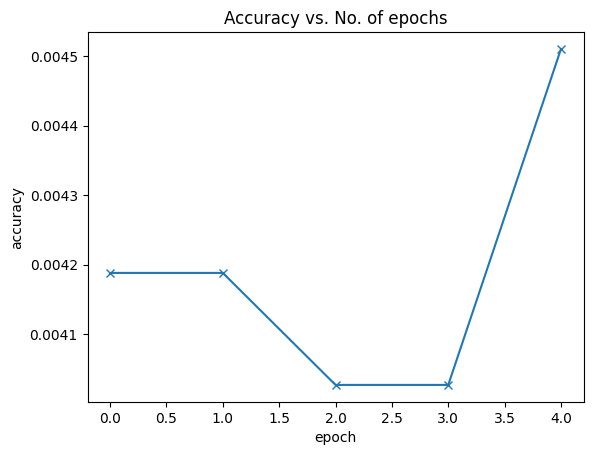

In [ ]:
plot_accuracies(history)

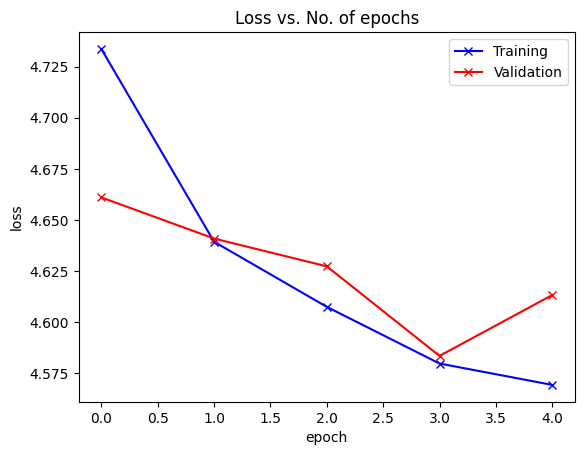

In [ ]:
plot_losses(history)

## Loss and optimizer

In [ ]:
learning_rate = 1e-3
momentum = 0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [ ]:
epoch_num = 2
for epoch in range(epoch_num):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = simple_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Testing data

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(2)))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))